# **Requirements**

Python 3.8.10

pythonnet 2.5.2

`pip install pythonnet==2.5.2`

In [ ]:
from Beam_shaper.classes.base_interactive import PythonZOSConnection
from Beam_shaper.classes.beam_shaper import BeamShaper
import sys
from importlib import metadata
import numpy as np
import matplotlib.pyplot as plt

print("Python version: ", sys.version)
print('Pythonnet version:', metadata.version('pythonnet'))

Python version:  3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Pythonnet version: 2.5.2


# **Connect to Zemax and initiate a system**

In [333]:
zos = PythonZOSConnection()
ZOSAPI = zos.ZOSAPI
TheApplication = zos.TheApplication
TheSystem = zos.TheSystem

print('Connected to OpticStudio')
print('Serial #: ', TheApplication.SerialCode)

print('ZOSAPI Mode: ', TheSystem.Mode)
print("Lens update mode: ", TheSystem.UpdateMode)

Connected to OpticStudio
Serial #:  20120530
ZOSAPI Mode:  0
Lens update mode:  1


In [312]:
galilean = BeamShaper(omega_0 = 2.366,
                  R_max=4.05,
                  r_max=4.05,
                  d=150,
                  n=1.46071,
                  type='Galilean'
                )

In [313]:
print(1.5 * galilean.omega_0)

3.5490000000000004


# **Set System Data**

In [314]:
# Define System Explore
SysExplore = TheSystem.SystemData

## **Set Title and Notes**

In [315]:
# Set Title and Notes
SysExplore.TitleNotes.Title = "Galilean Beam Shaper"
SysExplore.TitleNotes.Notes = "Galilean beam shaper design, turning a Gaussian into a flat-top beam."
SysExplore.TitleNotes.Author = "Ziyi Xiong"

## **Set Aperture**

In [316]:
# Set Aperture
SysExplore.Aperture.ApertureType = ZOSAPI.SystemData.ZemaxApertureType.EntrancePupilDiameter
SysExplore.Aperture.ApertureValue = galilean.r_max * 2

SysExplore.Aperture.ApodizationType = 1 # 0: Uniform, 1: Gaussian, 2: Cosine Cubed
SysExplore.Aperture.ApodizationFactor = galilean.apodization_factor # Apodization factor for Gaussian

## **Set Fields**

In [317]:
# Set Fields
SysExplore.Fields.SetFieldType(ZOSAPI.SystemData.FieldType.ParaxialImageHeight)
#SysExplore.Fields.ApplyFieldWizard(ZOSAPI.SystemData.FieldPattern.EqualAreaY, 9, 6.6, 0, 0, 0, True, False)

## **Set Wavelengths**

### **Via Presets**

In [318]:
# SysExplore.Wavelengths.SelectWavelengthPreset(ZOSAPI.SystemData.WavelengthPreset.FdC_Visible)

### **Customize Wavelengths**

In [319]:
SysExplore.Wavelengths.GetWavelength(1).Wavelength = 0.532

### **Remove Wavelengths**

In [320]:
# if num_wavelengths > 1: [SysExplore.Wavelengths.RemoveWavelength(i) for i in range(num_wavelengths, 1, -1)]

# **Set Lens Data**

In [336]:
SysLDE = TheSystem.LDE

## **Add Surfaces**

In [322]:
num_surfaces = SysLDE.NumberOfSurfaces

if num_surfaces == 3:
    for i in range(5): # range(4) = [0, 1, 2, 3]
        SysLDE.AddSurface()

num_surfaces = SysLDE.NumberOfSurfaces
print("Number of surfaces after insertion: ", num_surfaces)

Number of surfaces after insertion:  8


## **Get and Set Surfaces**

In [337]:
# Use a list to store all surfaces objects
Surface=[SysLDE.GetSurfaceAt(i) for i in range(0, num_surfaces)] 

## **Set Surface Data**

### **Set Stop**

In [324]:
Surface[4].IsStop = True 

### **Set Lens Data**

In [325]:
Surface[1].Thickness = 5
Surface[1].Comment = "Dummy"

Surface[2].Thickness = 3
MaterialModel1 = Surface[2].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
MaterialModel1.IndexNd = galilean.n
Surface[2].MaterialCell.SetSolveData(MaterialModel1)
Surface[2].SemiDiameter = galilean.r_max
Surface[2].MechanicalSemiDiameter = galilean.r_max

Surface[3].Thickness = galilean.d
Surface[3].Radius = galilean.r_c1
Surface[3].Conic = galilean.k_1
Surface[3].SemiDiameter = galilean.r_max
Surface[3].MechanicalSemiDiameter = galilean.r_max

Surface[5].Thickness = 3
MaterialModel2 = Surface[5].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
MaterialModel2.IndexNd = galilean.n
Surface[5].MaterialCell.SetSolveData(MaterialModel2)
Surface[5].Radius = galilean.r_c2
Surface[5].Conic = galilean.k_2
#Surface[4].SemiDiameter = galilean.R_max
#Surface[4].MechanicalSemiDiameter = galilean.R_max

Surface[6].Thickness = 10
#Surface[5].SemiDiameter = galilean.R_max
#Surface[5].MechanicalSemiDiameter = galilean.R_max

## **Optimization**

### **Set Variables**

In [326]:
Surface[3].RadiusCell.MakeSolveVariable()
Surface[3].ConicCell.MakeSolveVariable()
Surface[5].RadiusCell.MakeSolveVariable()
Surface[5].ConicCell.MakeSolveVariable()


True

### **Set Operands**

In [334]:
TheMFE = TheSystem.MFE

In [ ]:

num_operands = TheMFE.NumberOfOperands

num_samples = 81 # Best number of samples found

if num_operands == 1:
    for i in range(2*num_samples):
        TheMFE.AddOperand()

num_operands = TheMFE.NumberOfOperands

print(num_operands)

REAY = ZOSAPI.Editors.MFE.MeritOperandType.REAY
REAB = ZOSAPI.Editors.MFE.MeritOperandType.REAB

R_max = Surface[5].SemiDiameter 


163


In [339]:
Operand_REAY = [TheMFE.GetOperandAt(2*i - 1) for i in range(1, num_samples+1)]
for i in range(len(Operand_REAY)):
    Operand_REAY[i].ChangeType(REAY)
    Operand_REAY[i].GetCellAt(2).IntegerValue = 4 # Nummber of surface
    Operand_REAY[i].Weight = 50.0
    py = i / (num_samples - 1) # uniform sampling ensuring sharpe edges
    Operand_REAY[i].GetCellAt(7).DoubleValue = py
    r = galilean.r_max * py
    R = R_max * np.sqrt(1 - np.exp(-2 * (r / galilean.omega_0)**2)) / np.sqrt(1 - np.exp(-2 * (galilean.r_max / galilean.omega_0)**2))
    Operand_REAY[i].Target = R

In [340]:
Operand_REAB = [TheMFE.GetOperandAt(2*i) for i in range(1, num_samples + 1)]
for i in range(len(Operand_REAB)):
    Operand_REAB[i].ChangeType(REAB)
    Operand_REAB[i].GetCellAt(2).IntegerValue = 7 # Nummber of surface
    Operand_REAB[i].Weight = 1.0
    py = i / (num_samples - 1)
    Operand_REAB[i].GetCellAt(7).DoubleValue = py
    Operand_REAB[i].Target = 0.0


In [341]:
EFFL = ZOSAPI.Editors.MFE.MeritOperandType.EFFL
# TheMFE.AddOperand()
Operand_EFFL = TheMFE.GetOperandAt(num_operands)
Operand_EFFL.ChangeType(EFFL)
Operand_EFFL.Target = 1e+10
Operand_EFFL.Weight = 1

<function matplotlib.pyplot.show(close=None, block=None)>

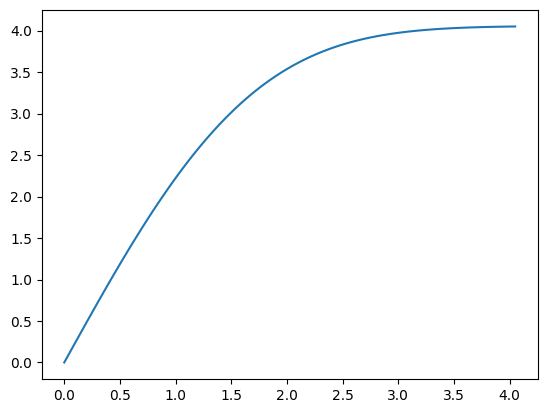

In [342]:
r = np.linspace(0, galilean.r_max, 100)
R = galilean._B * np.sqrt(1 - np.exp(-2 * (r / galilean.omega_0)**2))

plt.figure()
plt.plot(r, R)
plt.show

### **Optimize**

In [ ]:
LocalOpt = TheSystem.Tools.OpenLocalOptimization()
LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Automatic
LocalOpt.NumberOfCores = 8
LocalOpt.RunAndWaitForCompletion()
LocalOpt.Close()